# Evaluación del caso “Trío no colineal con planeta errante”

Exploramos un sistema de tres cuerpos inicialmente no colineales: dos estrellas masivas y un planeta errante que parte con desplazamiento lateral. Buscamos combinaciones de masa que reduzcan la sensibilidad caótica y mantengan la órbita del planeta dentro de un lazo estable durante integraciones largas.

> **Interpretación**
> - Un λ reducido indica que el planeta soporta mejor las perturbaciones y permanece ligado al sistema.
> - La penalización de periodicidad ayuda a mantener la topología orbital tras miles de unidades de tiempo, evitando salidas balísticas.


## Preparación del entorno

Localizamos la carpeta raíz `two_body`, la añadimos a `sys.path` y exponemos `PARENT` para reutilizar módulos comunes del repositorio. Garantizamos que los imports funcionen sin importar la ruta desde la que se ejecute el notebook.


In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
while PROJECT_ROOT.name != "two_body" and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

if PROJECT_ROOT.name != "two_body":
    raise RuntimeError("No se encontró la carpeta two_body")

PARENT = PROJECT_ROOT.parent  # directorio que contiene a two_body
if str(PARENT) not in sys.path:
    sys.path.insert(0, str(PARENT))

print("PYTHONPATH += ", PARENT)


PYTHONPATH +=  C:\Users\emicr\Documents\CODIGOS_FUENTES\TrabajoTerminal\collision_of_two_bodies


## Dependencias principales
Importamos los componentes clave del pipeline:
- `Config` y utilidades de seeding.
- El controlador híbrido (GA + refinamiento).
- Herramientas de visualización y simulación REBOUND.
- `numpy` para cualquier análisis adicional.


In [2]:
from two_body import Config, set_global_seeds
from two_body.core.telemetry import setup_logger
from two_body.logic.controller import ContinuousOptimizationController
from two_body.presentation.visualization import Visualizer as PlanarVisualizer
from two_body.presentation.triDTry import Visualizer as Visualizer3D
from two_body.simulation.rebound_adapter import ReboundSim
import numpy as np
from pathlib import Path  # si quieres guardar animaciones/figuras


## Instrumentación de rendimiento

Activamos las variables de entorno de la suite de timings y cargamos `time_block`, `latest_timing_csv`, etc. Esto nos permitirá auditar qué tan costosa es cada fase (integración short/long, refinamiento continuo, métricas).


In [3]:
import os
os.environ["PERF_TIMINGS_ENABLED"] = "1"
os.environ.setdefault("PERF_TIMINGS_JSONL", "0")

from two_body.perf_timings.timers import time_block
from two_body.perf_timings import latest_timing_csv, read_timings_csv, parse_sections_arg, filter_rows


## Logging amigable para notebooks

Definimos un `NotebookHandler` que acumula los mensajes del optimizador y los muestra en vivo dentro de la celda. Mantiene la salida legible mientras corren las generaciones y el refinamiento continuo.


In [4]:
import logging
from IPython.display import display, Markdown

class NotebookHandler(logging.Handler):
    def __init__(self):
        super().__init__()
        self.lines = []

    def emit(self, record):
        msg = self.format(record)
        self.lines.append(msg)
        print(msg)  # aparece en la celda conforme avanza

handler = NotebookHandler()
handler.setFormatter(logging.Formatter("[%(asctime)s] %(levelname)s - %(message)s"))

logger = setup_logger(level="DEBUG")
logger.handlers.clear()          # quita otros handlers previos
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)


## Configuración del escenario “Trío no colineal”

El diccionario `case` establece:
- Integraciones prolongadas (`t_end_long = 12000`, `dt = 0.06`) con `whfast`.
- Condiciones iniciales no colineales: dos estrellas desplazadas y un planeta errante cerca del eje Y.
- Rangos de masa relativamente amplios para permitir que el GA redistribuya masa entre los tres cuerpos.
- Parámetros evolutivos moderados (`pop_size = 110`, `mutation = 0.08`, etc.) y penalización de periodicidad (`periodicity_weight = 0.1`) para favorecer órbitas reincidentes.


In [5]:
case = {
    # Integración
    "t_end_short": 80.0,
    "t_end_long": 1200.0,
    "dt": 0.15,
    "integrator": "whfast",           # pasos uniformes ≈ estable + rápido

    # Condiciones iniciales (tres cuerpos no colineales)
    "r0": (
        (-2.5, 0.0, 0.0),             # estrella 1
        (2.3, 0.2, 0.0),              # estrella 2
        (0.2, 1.8, 0.0),              # planeta errante
    ),
    "v0": (
        (0.0, -0.55, 0.0),
        (0.0, 0.45, 0.0),
        (-0.6, 0.0, 0.0),
    ),

    # Rango de masas amplio (caos y asimetría)
    "mass_bounds": (
        (0.3, 2.5),                   # estrella mayor
        (0.15, 1.5),                  # estrella secundaria
        (1e-4, 3e-1),                 # tercer cuerpo pequeño a intermedio
    ),
    "G": 4 * np.pi**2, 
    "periodicity_weight": 0.02,       # valorar ligerísima cercanía orbital sin perder caos

    # GA / búsqueda continua (mucha exploración inicial)
    "pop_size": 32,
    "n_gen_step": 1,
    "crossover": 0.9,
    "mutation": 0.12,
    "elitism": 2,
    "seed": 98765,

    # Control de ejecución (promueve explotación posterior)
    "max_epochs": 18,
    "top_k_long": 14,
    "stagnation_window": 5,
    "stagnation_tol": 1e-3,
    "local_radius": 0.08,
    "radius_decay": 0.82,
    "time_budget_s": 600.0,
    "eval_budget": 6000,

    # Artefactos / salida
    "artifacts_dir": "artifacts/caso04_caotico",
    "save_plots": True,
    "headless": False,
}

In [6]:
from two_body.logic.controller import ContinuousOptimizationController
from two_body.core.config import Config
from two_body.core.telemetry import setup_logger
from two_body.core.cache import HierarchicalCache

cfg = Config(**case)
logger = setup_logger()

## Validación rápida del estimador de Lyapunov

Antes de lanzar el controlador, construimos una simulación con las masas promedio y ejecutamos `LyapunovEstimator.mLCE`. Esto sirve como smoke test para confirmar que el integrador produce trayectorias razonables y que el cálculo de λ responde al nuevo escenario.


In [7]:
from two_body.simulation.rebound_adapter import ReboundSim
from two_body.simulation.lyapunov import LyapunovEstimator

masses = tuple(np.mean(bounds) for bounds in cfg.mass_bounds)
sim = ReboundSim(G=cfg.G, integrator=cfg.integrator).setup_simulation(
    masses, cfg.r0[:len(masses)], cfg.v0[:len(masses)]
)
estimator = LyapunovEstimator()
ret = estimator.mLCE({"sim": sim, "dt": cfg.dt, "t_end": cfg.t_end_short, "masses": masses})
print(ret)


{'lambda': -0.010947911368120887, 'series': None, 'meta': {'steps': 534, 'dt': 0.15, 'n_bodies': 3, 'masses': (1.4, 0.825, 0.15005), 'impl': 'rebound_megno'}}


c:\Users\emicr\anaconda3\envs\grav2body\Lib\site-packages\rebound\__init__.py:58: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Recarga del evaluador de fitness

Si se modificó `two_body.logic.fitness`, recargamos el módulo con `importlib.reload` y reinstanciamos `setup_logger`. Así garantizamos que el notebook utilice la versión fresca del evaluador antes de iniciar la optimización.


In [8]:
import logging
import importlib

from two_body.core.telemetry import setup_logger
import two_body.logic.fitness as fitness_mod

importlib.reload(fitness_mod)                # recoge el código nuevo
from two_body.logic.fitness import FitnessEvaluator  # vuelve a importar la clase

logger = setup_logger(level="INFO")         # asegura nivel INFO
logger.setLevel(logging.INFO)
for handler in logger.handlers:
    handler.setLevel(logging.INFO)


## Ejecución del controlador híbrido

Instanciamos `Config`, el `logger` y `ContinuousOptimizationController`, y envolvemos `controller.run()` dentro de `time_block("notebook_run")` para medir la ejecución total (GA + refinamiento continuo) sobre el sistema no colineal.


In [9]:
print(cfg.mass_bounds, cfg.max_epochs, cfg.eval_budget)

((0.3, 2.5), (0.15, 1.5), (0.0001, 0.3)) 18 6000


In [10]:
with time_block("notebook_run", extra={"source": "Caso01.ipynb"}):
    controller = ContinuousOptimizationController(cfg, logger=logger)
    results = controller.run()

[2025-10-31 11:52:33,853] INFO - Starting optimization | pop=32 | dims=3 | time_budget=600.0s | eval_budget=6000


c:\Users\emicr\anaconda3\envs\grav2body\Lib\site-packages\rebound\simulation.py:259: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)


[2025-10-31 11:52:34,212] INFO - Epoch 0 | new global best (short) lambda=-0.015537 | fitness=-4.285341 | penalty=215.043884 | masses=(1.312842, 1.427077, 0.199071)
[2025-10-31 11:52:35,677] INFO - Epoch 0 complete | lambda_short=-0.015537 | fitness_short=-4.285341 | lambda_best=-0.015537 | fitness_best=-4.285341 | evals short/long=32/14 | total evals=46 | radius=0.0800
[2025-10-31 11:52:35,910] INFO - Epoch 1 | new global best (short) lambda=-0.133072 | fitness=-1.284304 | penalty=70.868806 | masses=(1.469731, 0.90737, 0.146247)
[2025-10-31 11:52:37,405] INFO - Epoch 1 complete | lambda_short=-0.133072 | fitness_short=-1.284304 | lambda_best=-0.133072 | fitness_best=-1.284304 | evals short/long=32/14 | total evals=92 | radius=0.0800
[2025-10-31 11:52:39,136] INFO - Epoch 2 complete | lambda_short=-1.785744 | fitness_short=-10.608413 | lambda_best=-0.133072 | fitness_best=-1.284304 | evals short/long=32/14 | total evals=138 | radius=0.0800
[2025-10-31 11:52:40,871] INFO - Epoch 3 compl

c:\Users\emicr\anaconda3\envs\grav2body\Lib\site-packages\pymoo\termination\ftol.py:27: RuntimeWarning: invalid value encountered in scalar subtract
  return max(0, prev - current)


[2025-10-31 11:52:42,569] INFO - Epoch 4 complete | lambda_short=-23.186196 | fitness_short=19.687298 | lambda_best=-23.186196 | fitness_best=19.687298 | evals short/long=32/14 | total evals=230 | radius=0.0800
[2025-10-31 11:52:44,284] INFO - Epoch 5 complete | lambda_short=-0.005964 | fitness_short=-8.280208 | lambda_best=-23.186196 | fitness_best=19.687298 | evals short/long=32/14 | total evals=276 | radius=0.0800
[2025-10-31 11:52:46,021] INFO - Epoch 6 complete | lambda_short=-1.844899 | fitness_short=-4.377689 | lambda_best=-23.186196 | fitness_best=19.687298 | evals short/long=32/14 | total evals=322 | radius=0.0800
[2025-10-31 11:52:47,883] INFO - Epoch 7 complete | lambda_short=-0.269028 | fitness_short=-3.116126 | lambda_best=-23.186196 | fitness_best=19.687298 | evals short/long=32/14 | total evals=368 | radius=0.0800
[2025-10-31 11:52:49,673] INFO - Epoch 8 complete | lambda_short=-0.024934 | fitness_short=-10.170199 | lambda_best=-23.186196 | fitness_best=19.687298 | evals

## Métricas base y comparación con la solución óptima

Calculamos el fitness del punto central (`center`) y lo comparamos con `results["best"]`. Guardamos `baseline_details` para estudiar la dinámica inicial y recuperamos `metrics` para posteriores visualizaciones de λ, fitness y estadísticas del experimento.


In [11]:
metrics = controller.metrics


In [12]:
results

{'status': 'completed',
 'best': {'masses': [0.580608717367432,
   1.2578731777555512,
   0.08417540037456164],
  'lambda': -99.30686856474583,
  'fitness': 49.34176630667801,
  'm1': 0.580608717367432,
  'm2': 1.2578731777555512,
  'm3': 0.08417540037456164},
 'evals': 828,
 'epochs': 18}

## Visualización de convergencia y órbitas

Generamos:
- `plot_lambda_evolution` y `plot_fitness_evolution` para revisar la trayectoria del GA.
- Integraciones 2D (`quick_view`) y 3D (`animate_3d`) con las masas óptimas, verificando si el planeta errante permanece confinado pese a la geometría no colineal.


In [13]:
from two_body.core.cache import HierarchicalCache
from two_body.logic.fitness import FitnessEvaluator

cache = HierarchicalCache()
evaluator = FitnessEvaluator(cache, cfg)

center = tuple((lo + hi) / 2.0 for lo, hi in cfg.mass_bounds)

baseline_fits, baseline_details = evaluator.evaluate_batch(
    [center],
    horizon="long",
    return_details=True,
)
baseline_fit = baseline_fits[0]
baseline_lambda = baseline_details[0].get("lambda")
if baseline_lambda is None or not np.isfinite(baseline_lambda):
    baseline_lambda = -baseline_fit

best_payload = results.get("best", {})
best_fit = best_payload.get("fitness")
best_lambda = best_payload.get("lambda")
if best_lambda is None and best_fit is not None:
    best_lambda = -best_fit

print(
    f"lambda inicial = {baseline_lambda:.6f}, "
    f"lambda optimo = {best_lambda if best_lambda is not None else 'N/A'}"
)


lambda inicial = 0.000031, lambda optimo = -99.30686856474583


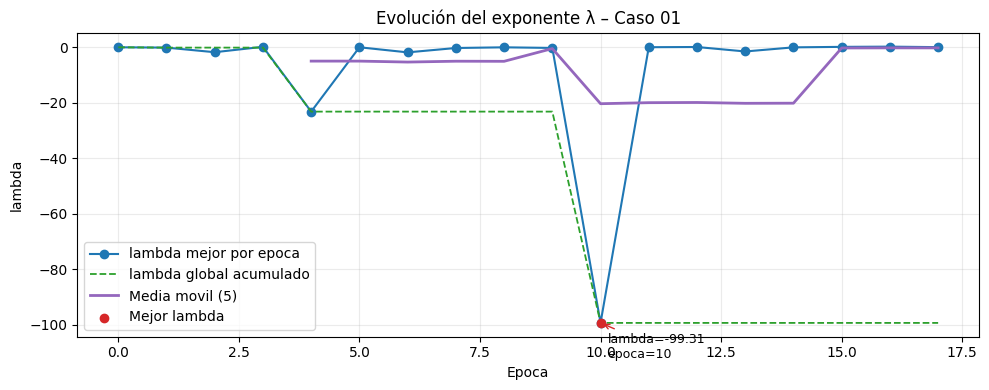

In [14]:
viz_3d = Visualizer3D(headless=cfg.headless)

_ = viz_3d.plot_lambda_evolution(
    lambda_history=metrics.best_lambda_per_epoch,
    epoch_history=metrics.epoch_history,
    title="Evolución del exponente λ – Caso 01",
    moving_average_window=5,   # opcional
)

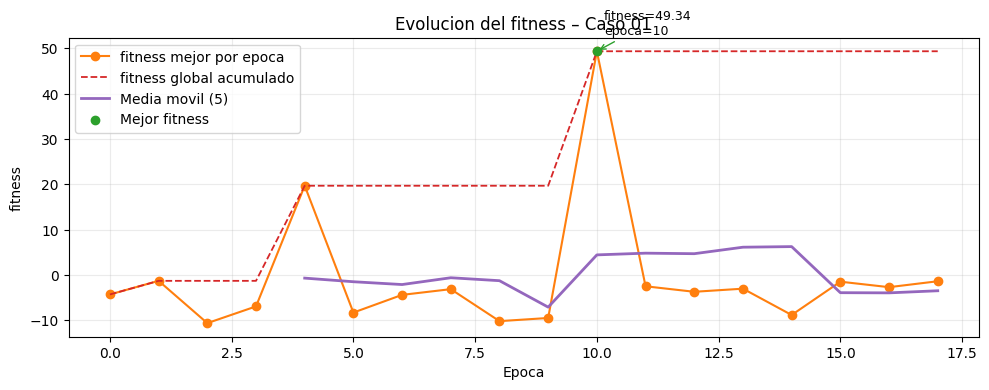

In [15]:
_ = viz_3d.plot_fitness_evolution(
    fitness_history=metrics.best_fitness_per_epoch,
    epoch_history=metrics.epoch_history,
    title="Evolucion del fitness – Caso 01",
    moving_average_window=5,
)


In [16]:
sim_builder = ReboundSim(G=cfg.G, integrator=cfg.integrator)
best_masses = tuple(results["best"]["masses"])

def _slice_vectors(vectors, count):
    if len(vectors) < count:
        raise ValueError("Config no tiene suficientes vectores iniciales")
    return tuple(tuple(float(coord) for coord in vectors[i]) for i in range(count))

r0 = _slice_vectors(cfg.r0, len(best_masses))
v0 = _slice_vectors(cfg.v0, len(best_masses))

sim = sim_builder.setup_simulation(best_masses, r0, v0)
traj = sim_builder.integrate(sim, t_end=cfg.t_end_long, dt=cfg.dt)
print("Trayectoria calculada con masas óptimas.")
print(traj.shape)
print(traj[-1])
xyz_tracks = [traj[:, i, :3] for i in range(traj.shape[1])]


Trayectoria calculada con masas óptimas.
(8000, 3, 6)
[[-1.56367249e+03 -3.80763361e+02  0.00000000e+00  4.13489166e-01
   1.14623638e+00  0.00000000e+00]
 [-1.56404652e+03 -3.74846543e+02  0.00000000e+00 -2.10073615e+00
  -9.89031803e-01  0.00000000e+00]
 [ 3.41578898e+04  8.22786629e+03  0.00000000e+00  2.85402176e+01
   6.87328770e+00  0.00000000e+00]]


In [ ]:
from two_body.scripts.demo_tierra import (
    summarize_trajectory,
    compute_total_energy,
    estimate_orbital_period,
)

summarize_trajectory(
    logger=logger,
    traj=traj,
    masses=best_masses,
    cfg=cfg,
)

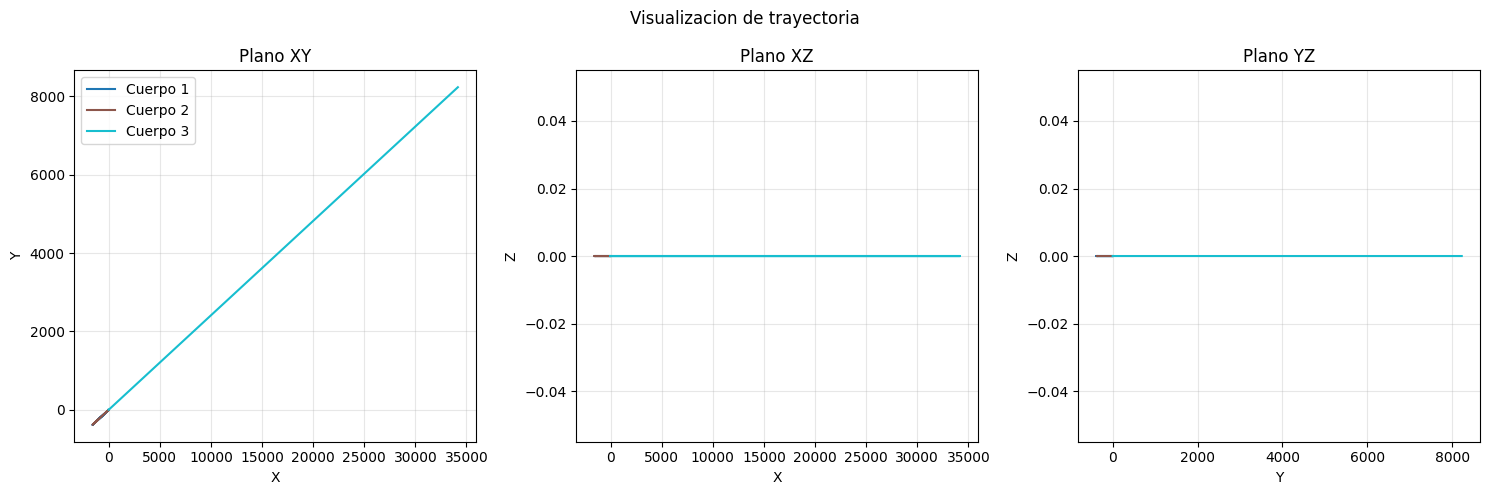

In [17]:
viz_planar = PlanarVisualizer(headless=cfg.headless)
_ = viz_planar.quick_view(xyz_tracks)  # usa una asignación para que Jupyter no duplique la figura

In [18]:
from IPython.display import HTML

import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 50  # MB

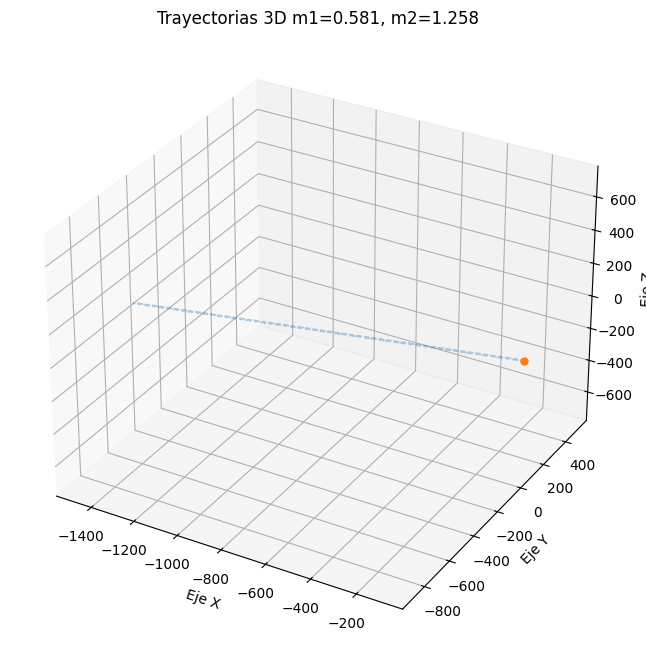

In [19]:
viz_3d = Visualizer3D(headless=False)

anim = viz_3d.animate_3d(
    trajectories=xyz_tracks[:][::10],
    interval_ms=50,
    title=f"Trayectorias 3D m1={best_masses[0]:.3f}, m2={best_masses[1]:.3f}",
    total_frames=len(xyz_tracks[0]),
)
#HTML(anim.to_jshtml())  

## Exportación de animaciones

Preparamos un `FFMpegWriter`, creamos `artifacts/caso04` y guardamos los MP4 tanto de la órbita como de la comparación de masas. Ajusta `fps`, `bitrate` o `dpi` si necesitas equilibrar rapidez y calidad de render.


In [ ]:
from matplotlib.animation import FFMpegWriter  # o PillowWriter para GIF

writer = FFMpegWriter(fps=1000 // 50, bitrate=2400)   # fps = 1000/interval_ms
output_path = Path("artifacts/caso04")                # ajusta a tu gusto
output_path.mkdir(parents=True, exist_ok=True)

anim.save(output_path / "trayectoria_optima.mp4", writer=writer)

In [ ]:
anim_mass = viz_3d.plot_mass_comparison(
    original_masses=center,
    optimized_masses=best_masses,
    body_labels=[f"Cuerpo {i+1}" for i in range(len(best_masses))],
    title="Comparativa de masas (Caso 01)",
)
#HTML(anim_mass.to_jshtml())  

In [ ]:
anim_mass.save(output_path / "comparativa_masas.mp4", writer=writer)

## Reporte de tiempos

Leemos el CSV más reciente de la instrumentación, mostramos una muestra y agrupamos por sección para identificar los cuellos de botella (por ejemplo, integración larga con tres cuerpos no colineales).


In [ ]:
import pandas as pd

csv_path = latest_timing_csv()
display(f"Usando CSV: {csv_path}")

rows = read_timings_csv(csv_path)
df = pd.DataFrame(rows)
display(df.head(10))

# Estadísticas rápidas por sección
section_stats = (
    df.groupby("section")["duration_us"]
    .agg(["count", "mean", "sum"])
    .sort_values("sum", ascending=False)
)
section_stats

In [ ]:
import os
import subprocess
from pathlib import Path
from IPython.display import Image, display

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != "two_body" and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent

env = os.environ.copy()
env["PYTHONPATH"] = str(PROJECT_ROOT)

run_id = df["run_id"].iloc[0]
cmd = [
    sys.executable,
    "scripts/plot_timings.py",
    "--run-id", str(run_id),
    "--top-n", "5",
]


print("Ejecutando:", " ".join(cmd))
result = subprocess.run(cmd, cwd=PROJECT_ROOT, env=env, text=True, capture_output=True)
print(result.stdout)
print(result.stderr)
result.check_returncode()

reports_dir = PROJECT_ROOT / "reports"

display(
    Image(filename=str(reports_dir / f"timeline_by_individual_{run_id}.png")),
    Image(filename=str(reports_dir / f"timeline_by_batch_{run_id}.png")),
    Image(filename=str(reports_dir / f"timeline_simulation_{run_id}.png")),
    Image(filename=str(reports_dir / f"pie_sections_{run_id}.png")),
)


In [ ]:
# from pathlib import Path
# 
# 
# output_path = Path("artifacts/animations/caso01_orbit.gif")
# output_path2 = Path("artifacts/animations/caso01_comparasion.gif")
# output_path.parent.mkdir(parents=True, exist_ok=True)
# 
# anim.save(
#     output_path,
#     writer="pillow",
#     fps=20,
#     dpi=100,          # opcional
# )
# 
# print(f"Animación 3D guardada en {output_path}")
# 